<a href="https://colab.research.google.com/github/Sonal-singh-02/FirstRepo/blob/main/crack_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-image

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from scipy import ndimage
from skimage import filters
from skimage import img_as_ubyte
from skimage.metrics import structural_similarity as ssim


Epoch 1/50
12/12 [==============================] - 12s 853ms/step - loss: 0.1713 - val_loss: 0.0715
Epoch 2/50
12/12 [==============================] - 10s 850ms/step - loss: 0.0944 - val_loss: 0.0691
Epoch 3/50
12/12 [==============================] - 8s 708ms/step - loss: 0.0946 - val_loss: 0.0698
Epoch 4/50
12/12 [==============================] - 10s 824ms/step - loss: 0.0947 - val_loss: 0.0699
Epoch 5/50
12/12 [==============================] - 10s 842ms/step - loss: 0.0948 - val_loss: 0.0700
Epoch 6/50
12/12 [==============================] - 8s 695ms/step - loss: 0.0948 - val_loss: 0.0700
Epoch 7/50
12/12 [==============================] - 10s 831ms/step - loss: 0.0948 - val_loss: 0.0700
Epoch 8/50
12/12 [==============================] - 10s 841ms/step - loss: 0.0948 - val_loss: 0.0700
Epoch 9/50
12/12 [==============================] - 9s 718ms/step - loss: 0.0948 - val_loss: 0.0700
Epoch 10/50
12/12 [==============================] - 10s 770ms/step - loss: 0.0948 - val_loss:

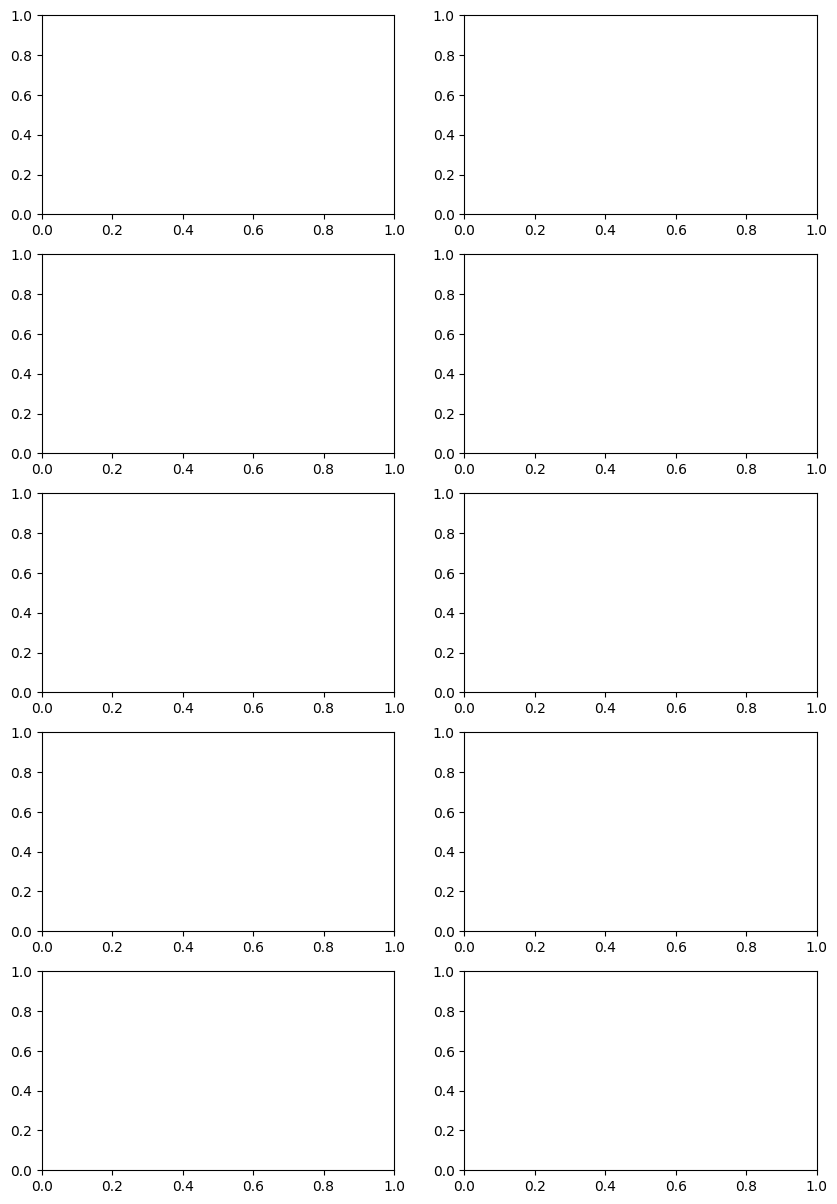

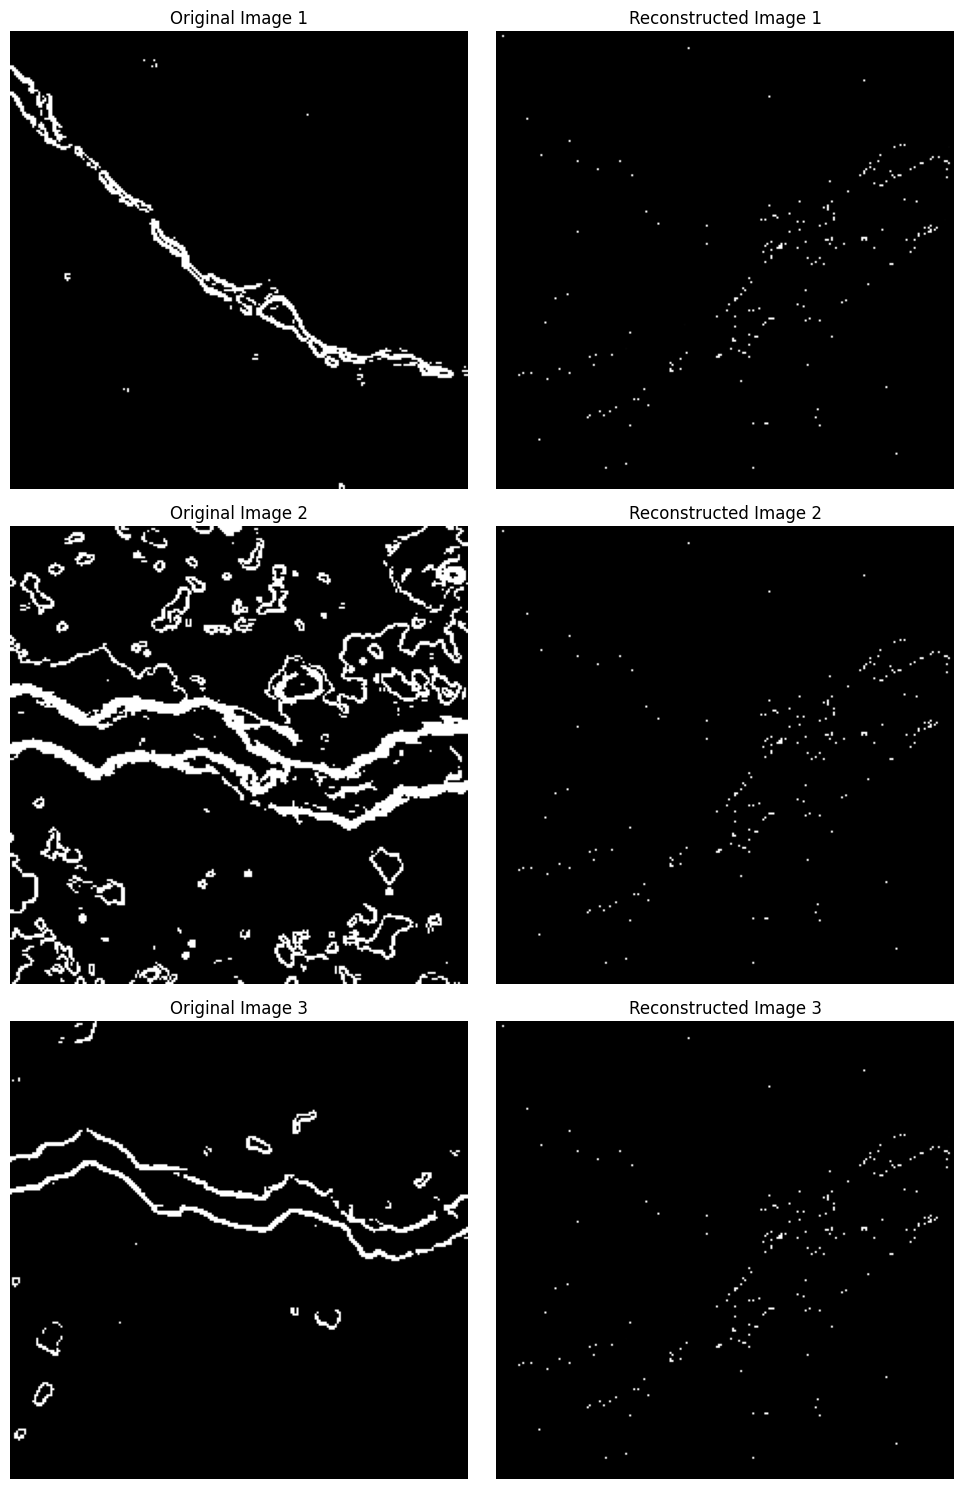

1/1 [==============================] - 0s 418ms/step
Mean Squared Error (MSE) - Training set: 0.09511466324329376
Structural Similarity Index (SSI) - Training set: 0.5693167993223306
Mean Squared Error (MSE) - Testing set: 0.0703810527920723
Structural Similarity Index (SSI) - Testing set: 0.6546632093448898


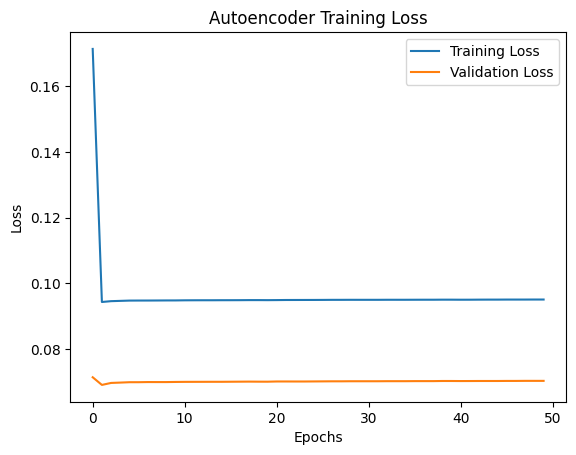

In [ ]:
import cv2
import numpy as np
from skimage import filters, measure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

# Function for RGB control method
def rgb_control(image):
    # Implement your RGB control method here
    # Example: Increase intensity in the red channel
    image[:, :, 0] = image[:, :, 0] * 1.5
    return image

# Function for grayscale (luminance)
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function for edge detection using Sobel filter
def sobel_edge_detection(image):
    return filters.sobel(image)



# Function for thresholding using Otsu's method
def otsu_thresholding(image):
    # Convert to 8-bit unsigned integer
    image = (image * 255).astype(np.uint8)

    _, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

# Function to create an autoencoder model
def create_autoencoder(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(np.prod(input_shape), activation='sigmoid'))
    model.add(Reshape(input_shape))
    return model

# Load and preprocess the dataset
dataset_path = '/content/drive/MyDrive/crack detection/less pics'  # Replace with the path to your dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

images = []
for file in image_files:
    image_path = os.path.join(dataset_path, file)
    original_image = cv2.imread(image_path)
    processed_image = rgb_control(original_image)
    processed_image = to_grayscale(processed_image)
    processed_image = sobel_edge_detection(processed_image)
    processed_image = otsu_thresholding(processed_image)
    processed_image = processed_image.astype('float32') / 255.0
    processed_image = np.reshape(processed_image, (processed_image.shape[0], processed_image.shape[1], 1))
    images.append(processed_image)

images = np.array(images)

# Split the dataset into training and testing sets
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

# Create and compile the autoencoder model
input_shape = train_images.shape[1:]
autoencoder = create_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder and save training history
history = autoencoder.fit(train_images, train_images, epochs=50, batch_size=1, shuffle=True, validation_data=(test_images, test_images))

# Evaluate the autoencoder on the testing set
reconstructed_images = autoencoder.predict(test_images)

# Display some original, preprocessed, and reconstructed images using Matplotlib
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))

# Display some original, preprocessed, and reconstructed images using Matplotlib
fig, axes = plt.subplots(nrows=min(5, len(test_images)), ncols=2, figsize=(10, 15))

for i in range(min(5, len(test_images))):
    axes[i, 0].imshow(test_images[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title(f'Reconstructed Image {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Calculate Mean Squared Error (MSE) for testing set
mse_test = np.mean((test_images - reconstructed_images)**2)

# Calculate Structural Similarity Index (SSI) for testing set
ssi_test = np.mean([ssim(img_as_ubyte(test_images[i, :, :, 0]), img_as_ubyte(reconstructed_images[i, :, :, 0])) for i in range(len(test_images))])

# Calculate Mean Squared Error (MSE) for training set
reconstructed_images_train = autoencoder.predict(train_images)
mse_train = np.mean((train_images - reconstructed_images_train)**2)

# Calculate Structural Similarity Index (SSI) for training set
ssi_train = np.mean([ssim(img_as_ubyte(train_images[i, :, :, 0]), img_as_ubyte(reconstructed_images_train[i, :, :, 0])) for i in range(len(train_images))])

# Display evaluation metrics
print(f'Mean Squared Error (MSE) - Training set: {mse_train}')
print(f'Structural Similarity Index (SSI) - Training set: {ssi_train}')

print(f'Mean Squared Error (MSE) - Testing set: {mse_test}')
print(f'Structural Similarity Index (SSI) - Testing set: {ssi_test}')

# Plot the training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()